In [5]:
import sys

import keras
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from numpy import array
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # to make any matplotlib plot automatically a 20x10

import configparser
config = configparser.ConfigParser()
config.read('lstmconfig.ini')

scaler = MinMaxScaler(feature_range=(0,1))
eco_tools_path = config['SETUP']['eco_tools_path']
sys.path.append(eco_tools_path)
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')

callbacks_list = [EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=2)]
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


In [6]:
point_name = config['PI']['point_name']
start = config['PI']['start']
end = config['PI']['end']
interval = config['PI']['interval']
calculation = config['PI']['calculation']

In [7]:
def create_mulitvariable_df(data):
    data.rename(columns={'aiTIT4045':'OAT'}, inplace=True)

    data["cdd"] = data.OAT - 65.0
    data.loc[data.cdd < 0, "cdd"] = 0
    data["hdd"] = 65.0 - data.OAT
    data.loc[data.hdd < 0, 'hdd'] = 0
    data["cdd2"] = data.cdd**2
    data["hdd2"] = data.hdd**2

    data2 = data.copy()
    ##FIX: if the dataframe passed does not have a month that the origial LSTM trained on, it wont be able
    ##to be used to predict!
    data2["MONTH"]= data2.index.month
    data2["MONTH"] = data2["MONTH"].astype('category')
    data2["TOD"] = data2.index.hour
    data2["TOD"] = data2["TOD"].astype('category')
    data2["DOW"] = data2.index.weekday
    data2["DOW"] = data2["DOW"].astype('category')
    print(f"data2: {data2['MONTH'].unique()}")
    ### Create dummy variables
    l3 = ["MONTH","TOD","DOW"]#,“WEEK”]#,“DOY”]
    data2 = pd.get_dummies(data=data2, columns=l3, drop_first=True)
 
    ### Create Weekend flag
    data2["WEEKEND"] = 0
    data2.loc[(data2.DOW_5 == 1) | (data2.DOW_6 == 1), 'WEEKEND'] = 1
    
    data2["shift1"] = data2.iloc[:,0].shift(2)

    data2["rolling24_mean"] = data2.iloc[:,0].rolling('24h').mean()
    data2["rolling24_max"] = data2.iloc[:,0].rolling('24h').max()
    data2["rolling24_min"] = data2.iloc[:,0].rolling('24h').min()
   
    data2.dropna(inplace=True)
    
    return data2

In [8]:
point_list = [point_name, 'aiTIT4045']
df = pc.get_stream_by_point(point_list, start = start, end = end, calculation = calculation, interval= interval)
df = df.dropna(how='any')
df.head()

Grabbing WebIDs ...
WebID collection complete!
21:15:20: Sending API request... Chunk 1 of 1
21:15:24: Response recieved for 2 tags! (3.98)


c:\users\josue\anaconda3\envs\tensorflow\lib\site-packages\pandas\core\arrays\datetimes.py:1027: FutureWarning: The errors argument is deprecated and will be removed in a future release. Use nonexistent='NaT' or nonexistent='raise' instead.
  "instead.", FutureWarning)


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2016-01-01 00:00:00,2550.633333,40.409643
2016-01-01 01:00:00,2535.975618,40.079128
2016-01-01 02:00:00,2538.258333,40.090998
2016-01-01 03:00:00,2548.635795,40.114107
2016-01-01 04:00:00,2556.464644,39.902123


In [9]:
def clean_train_data(df):
    #mask1 = (df[point_name] > 2400 )& (df.index.year < 2019)
    mask1 = (df[point_name] > 2400 )
    df1 = df.loc[mask1]
    mask2 = (df.index.year>=2019)
    df2 = df.loc[mask2]
    return df1, df2
    #return pd.concat([df1,df2])   

In [10]:
df, df1 = clean_train_data(df)
print(f"df: {df.shape} \n df1: {df1.shape}")

df: (30813, 2) 
 df1: (4710, 2)


In [11]:
df = create_mulitvariable_df(df)
df1 = create_mulitvariable_df(df1)
df.head()

data2: [1, 2, 3, 4, 5, ..., 8, 9, 10, 11, 12]
Length: 12
Categories (12, int64): [1, 2, 3, 4, ..., 9, 10, 11, 12]
data2: [1, 2, 3, 4, 5, 6, 7]
Categories (7, int64): [1, 2, 3, 4, 5, 6, 7]


,GBSF_Electricity_Demand_kBtu,OAT,cdd,hdd,cdd2,hdd2,MONTH_2,MONTH_3,MONTH_4,MONTH_5,...,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,WEEKEND,shift1,rolling24_mean,rolling24_max,rolling24_min
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 02:00:00,2538.258333,40.090998,0.0,24.909002,0.0,620.458395,0,0,0,0,...,0,0,1,0,0,0,2550.633333,2541.622428,2550.633333,2535.975618
2016-01-01 03:00:00,2548.635795,40.114107,0.0,24.885893,0.0,619.307679,0,0,0,0,...,0,0,1,0,0,0,2535.975618,2543.375770,2550.633333,2535.975618
2016-01-01 04:00:00,2556.464644,39.902123,0.0,25.097877,0.0,629.903431,0,0,0,0,...,0,0,1,0,0,0,2538.258333,2545.993545,2556.464644,2535.975618
2016-01-01 05:00:00,2541.260449,39.394233,0.0,25.605767,0.0,655.655326,0,0,0,0,...,0,0,1,0,0,0,2548.635795,2545.204696,2556.464644,2535.975618
2016-01-01 06:00:00,2569.566667,38.751869,0.0,26.248131,0.0,688.964360,0,0,0,0,...,0,0,1,0,0,0,2556.464644,2548.684977,2569.566667,2535.975618


In [12]:
np.setdiff1d(df.columns,df1.columns)


array(['MONTH_10', 'MONTH_11', 'MONTH_12', 'MONTH_8', 'MONTH_9'],
      dtype=object)

In [13]:
def scale_keras(X, y):
    # normalize the dataset
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler((0, 1))
    X = scaler_x.fit_transform(X)
    y = scaler_y.fit_transform(np.array(y).reshape((-1,1)))
    # split into train and test sets
    train_size = int(len(X) * 0.7)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size], X[test_size:len(X)]
    y_train, y_test = y[0:train_size], y[test_size:len(y)]
    return X_train, X_test, y_train, y_test, scaler_x, scaler_y

In [14]:
y = df[point_name]
X = df.drop(columns=point_name)
y1 = df1[point_name]
X1 = df1.drop(columns=point_name)

In [15]:
X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_keras(X, y)
X1_train, X1_test, y1_train, y1_test, scaler_x1, scaler_y1 = scale_keras(X1, y1)

In [16]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X1_train = np.reshape(X1_train, (X1_train.shape[0], 1, X1_train.shape[1]))
X1_test = np.reshape(X1_test, (X1_test.shape[0], 1, X1_test.shape[1]))

In [17]:
train = DataFrame()
val = DataFrame()
np.random.seed(42)
for i in range(1):
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
    model.add(LSTM(100))
    model.add(Dense(1))
    model.compile(optimizer = Adam(lr = 0.001), loss = 'mean_squared_error')
    #X,y = get_train()
    #valX, valY = get_val()
    # fit model
    history = model.fit(X_train, y_train, epochs = 400, validation_split = 0.3, shuffle = False)
    # story history
    train[str(i)] = history.history['loss']
    val[str(i)] = history.history['val_loss']



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 15096 samples, validate on 6471 samples
Epoch 1/400
15096/15096 [==============================] - 6s 420us/step - loss: 0.0092 - val_loss: 0.0031
Epoch 2/400
15096/15096 [==============================] - 4s 278us/step - loss: 0.0023 - val_loss: 0.0031
Epoch 3/400
15096/15096 [==============================] - 4s 287us/step - loss: 0.0023 - val_loss: 0.0041
Epoch 4/400
15096/15096 [==============================] - 4s 280us/step - loss: 0.0023 - val_loss: 0.0052
Epoch 5/400
15096/15096 [==============================] - 4s 281us/step - loss: 0.0021 - val_loss: 0.0046
Epoch 6/400
15096/15096 [==============================] - 4s 283us/step - loss: 0.0020 - val_loss: 0.0039
Epoch 7/400
15096/15096 [==============================] - 4s 279us/step - loss: 0.0020 - val_loss: 0.0037
Epoch 8/400
15096/15096 [==============================] - 4s 280us/step - loss: 0

15096/15096 [==============================] - 5s 313us/step - loss: 0.0011 - val_loss: 0.0017
Epoch 72/400
15096/15096 [==============================] - 5s 314us/step - loss: 0.0011 - val_loss: 0.0017
Epoch 73/400
15096/15096 [==============================] - 5s 304us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 74/400
15096/15096 [==============================] - 4s 295us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 75/400
15096/15096 [==============================] - 5s 306us/step - loss: 0.0010 - val_loss: 0.0016
Epoch 76/400
15096/15096 [==============================] - 5s 310us/step - loss: 0.0010 - val_loss: 0.0016
Epoch 77/400
15096/15096 [==============================] - 5s 316us/step - loss: 0.0010 - val_loss: 0.0016
Epoch 78/400
15096/15096 [==============================] - 5s 314us/step - loss: 0.0010 - val_loss: 0.0016
Epoch 79/400
15096/15096 [==============================] - 5s 312us/step - loss: 0.0010 - val_loss: 0.0017
Epoch 80/400
15096/15096 [===============

15096/15096 [==============================] - 4s 295us/step - loss: 7.1627e-04 - val_loss: 0.0018
Epoch 145/400
15096/15096 [==============================] - 4s 287us/step - loss: 7.1312e-04 - val_loss: 0.0018
Epoch 146/400
15096/15096 [==============================] - 4s 284us/step - loss: 7.1064e-04 - val_loss: 0.0018
Epoch 147/400
15096/15096 [==============================] - 4s 284us/step - loss: 7.0767e-04 - val_loss: 0.0018
Epoch 148/400
15096/15096 [==============================] - 4s 284us/step - loss: 7.0495e-04 - val_loss: 0.0018
Epoch 149/400
15096/15096 [==============================] - 4s 283us/step - loss: 7.0202e-04 - val_loss: 0.0018
Epoch 150/400
15096/15096 [==============================] - 4s 282us/step - loss: 6.9967e-04 - val_loss: 0.0018
Epoch 151/400
15096/15096 [==============================] - 4s 287us/step - loss: 6.9693e-04 - val_loss: 0.0018
Epoch 152/400
15096/15096 [==============================] - 4s 287us/step - loss: 6.9481e-04 - val_loss: 0.00

15096/15096 [==============================] - 4s 281us/step - loss: 5.6575e-04 - val_loss: 0.0017
Epoch 217/400
15096/15096 [==============================] - 4s 279us/step - loss: 5.6398e-04 - val_loss: 0.0017
Epoch 218/400
15096/15096 [==============================] - 4s 280us/step - loss: 5.6226e-04 - val_loss: 0.0017
Epoch 219/400
15096/15096 [==============================] - 4s 281us/step - loss: 5.6009e-04 - val_loss: 0.0017
Epoch 220/400
15096/15096 [==============================] - 4s 281us/step - loss: 5.5880e-04 - val_loss: 0.0017
Epoch 221/400
15096/15096 [==============================] - 4s 280us/step - loss: 5.5688e-04 - val_loss: 0.0017
Epoch 222/400
15096/15096 [==============================] - 4s 280us/step - loss: 5.5524e-04 - val_loss: 0.0017
Epoch 223/400
15096/15096 [==============================] - 4s 279us/step - loss: 5.5392e-04 - val_loss: 0.0017
Epoch 224/400
15096/15096 [==============================] - 4s 279us/step - loss: 5.5188e-04 - val_loss: 0.00

15096/15096 [==============================] - 4s 280us/step - loss: 4.5637e-04 - val_loss: 0.0019
Epoch 289/400
15096/15096 [==============================] - 4s 280us/step - loss: 4.5527e-04 - val_loss: 0.0019
Epoch 290/400
15096/15096 [==============================] - 4s 280us/step - loss: 4.5390e-04 - val_loss: 0.0019
Epoch 291/400
15096/15096 [==============================] - 4s 280us/step - loss: 4.5313e-04 - val_loss: 0.0019
Epoch 292/400
15096/15096 [==============================] - 4s 277us/step - loss: 4.5148e-04 - val_loss: 0.0019
Epoch 293/400
15096/15096 [==============================] - 4s 280us/step - loss: 4.5147e-04 - val_loss: 0.0019
Epoch 294/400
15096/15096 [==============================] - 4s 278us/step - loss: 4.4930e-04 - val_loss: 0.0019
Epoch 295/400
15096/15096 [==============================] - 4s 280us/step - loss: 4.4864e-04 - val_loss: 0.0019
Epoch 296/400
15096/15096 [==============================] - 4s 277us/step - loss: 4.4778e-04 - val_loss: 0.00

15096/15096 [==============================] - 4s 283us/step - loss: 3.8768e-04 - val_loss: 0.0023
Epoch 361/400
15096/15096 [==============================] - 4s 279us/step - loss: 3.8604e-04 - val_loss: 0.0023
Epoch 362/400
15096/15096 [==============================] - 4s 282us/step - loss: 3.8564e-04 - val_loss: 0.0023
Epoch 363/400
15096/15096 [==============================] - 4s 278us/step - loss: 3.8422e-04 - val_loss: 0.0023
Epoch 364/400
15096/15096 [==============================] - 4s 282us/step - loss: 3.8280e-04 - val_loss: 0.0023
Epoch 365/400
15096/15096 [==============================] - 4s 279us/step - loss: 3.8403e-04 - val_loss: 0.0023
Epoch 366/400
15096/15096 [==============================] - 4s 280us/step - loss: 3.8282e-04 - val_loss: 0.0022
Epoch 367/400
15096/15096 [==============================] - 4s 279us/step - loss: 3.8126e-04 - val_loss: 0.0022
Epoch 368/400
15096/15096 [==============================] - 4s 281us/step - loss: 3.8077e-04 - val_loss: 0.00

In [18]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

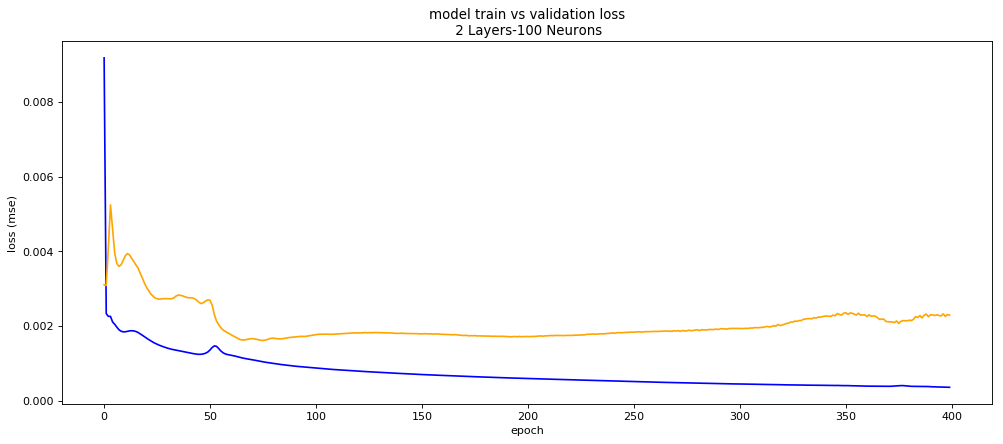

In [19]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train, color='blue', label='train')
plt.plot(val, color='orange', label='validation')
plt.title('model train vs validation loss\n 2 Layers-100 Neurons')
plt.ylabel('loss (mse)')
plt.xlabel('epoch')
#plt.savefig('new_300_epochs.png')
plt.show()

R2 of train = 0.966
R2 of test = 0.939

RMSE of train = 43.22
RMSE of test = 57.763

MAE of train = -17.325
MAE of test = -19.443


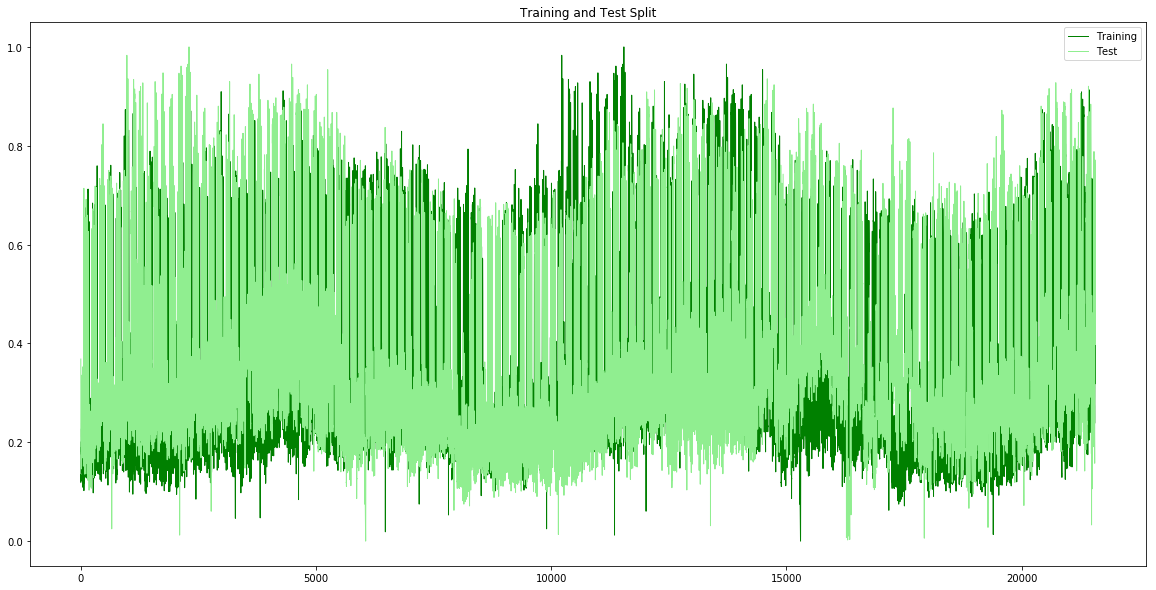

<Figure size 1296x144 with 0 Axes>

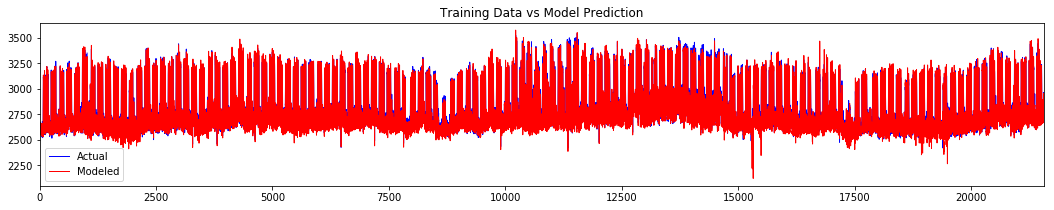

<Figure size 1296x144 with 0 Axes>

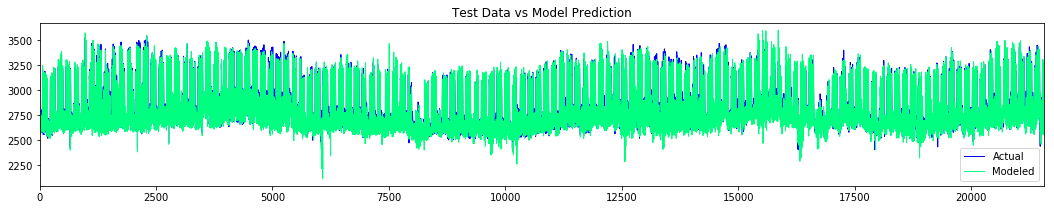

In [20]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
plt.plot(y_train, linewidth=1, color='green')
plt.plot(y_test, color='lightgreen', linewidth=1)
plt.title("Training and Test Split")
plt.legend(['Training','Test'])

pred_train = history.model.predict(X_train)
pred_train_inv = scaler_y.inverse_transform(pred_train.reshape(-1,1))
pred_test = history.model.predict(X_test)
pred_test_inv = scaler_y.inverse_transform(pred_test.reshape(-1,1))

plt.figure(figsize=(18,2))
training_comparison = pd.DataFrame({"Actual":scaler_y.inverse_transform(y_train).reshape((-1,)),
                                   "Modeled":pred_train_inv.reshape((-1,))}, index=range(len(y_train)))
training_comparison.sort_index().plot(figsize=(18,3),
                         title="Training Data vs Model Prediction",
                         linewidth=1,
                         color=['blue','red'])
 
plt.figure(figsize=(18,2))
test_comparison = pd.DataFrame({"Actual":scaler_y.inverse_transform(y_test).reshape((-1,)),
                                   "Modeled":pred_test_inv.reshape((-1,))}, index=range(len(y_test)))
test_comparison.sort_index().plot(figsize=(18,3),
                     title="Test Data vs Model Prediction",
                     linewidth=1,
                     colormap='winter')

r2_train = r2_score(scaler_y.inverse_transform(y_train).reshape((-1,)), pred_train_inv.reshape(-1,1))
print(f"R2 of train = {round(r2_train,3)}")
r2_test = r2_score(scaler_y.inverse_transform(y_test).reshape((-1,)), pred_test_inv.reshape(-1,1))
print(f"R2 of test = {round(r2_test,3)}")
print()
rmse_train = math.sqrt(mean_squared_error(scaler_y.inverse_transform(y_train).reshape((-1,)), pred_train_inv.reshape(-1,1)))
print(f"RMSE of train = {round(rmse_train,3)}")
rmse_test = math.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test).reshape((-1,)), pred_test_inv.reshape(-1,1)))
print(f"RMSE of test = {round(rmse_test,3)}")
print()
mae_train = np.median((pred_train_inv.reshape(-1,1) - scaler_y.inverse_transform(y_train).reshape((-1,))))
print(f"MAE of train = {round(mae_train,3)}")
mae_test = np.median((pred_test_inv.reshape(-1,1) - scaler_y.inverse_transform(y_test).reshape((-1,))))
print(f"MAE of test = {round(mae_test,3)}")